<a href="https://colab.research.google.com/github/jejjohnson/gp_model_zoo/blob/master/code/numpyro/exact_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EGP (MCMC Schemes)

A demo notebook showing how solve a simple regression problem using an exact Gaussian Process (GP). This GP is trained with MLE and we will use the numpyro library as the backend for the inference.

In [1]:
# #@title Install Packages
# %%capture
# !pip install pyprojroot jax jaxlib chex numpyro flax distrax numpy pandas seaborn matplotlib corner loguru nb_black sklearn

In [2]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])

# append to path
sys.path.append(str(root))

In [3]:
# @title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# JAX SETTINGS
import jax
import jax.numpy as jnp
import jax.random as random
from jax.config import config

config.update("jax_enable_x64", True)


# JAX UTILITY LIBRARIES
import chex

# NUMPYRO SETTINGS
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, Trace_ELBO

# NUMPY SETTINGS
import numpy as np

np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns

sns.set_context(context="poster", font_scale=0.8)

# PANDAS SETTINGS
import pandas as pd

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import loguru

%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [4]:
# ==========================
# INITIALIZE LOGGER
# ==========================
import wandb

wandb_logger = wandb.init(project="egp_1_1", entity="ipl_uv")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ml4floods (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
wandb.config.model = "sparse"
wandb.config.exp = "demo_1d"
wandb.config.n_train = 1_000
wandb.config.n_test = 1_000
wandb.config.x_noise = 0.3
wandb.config.y_noise = 0.01
wandb.config.seed = 123

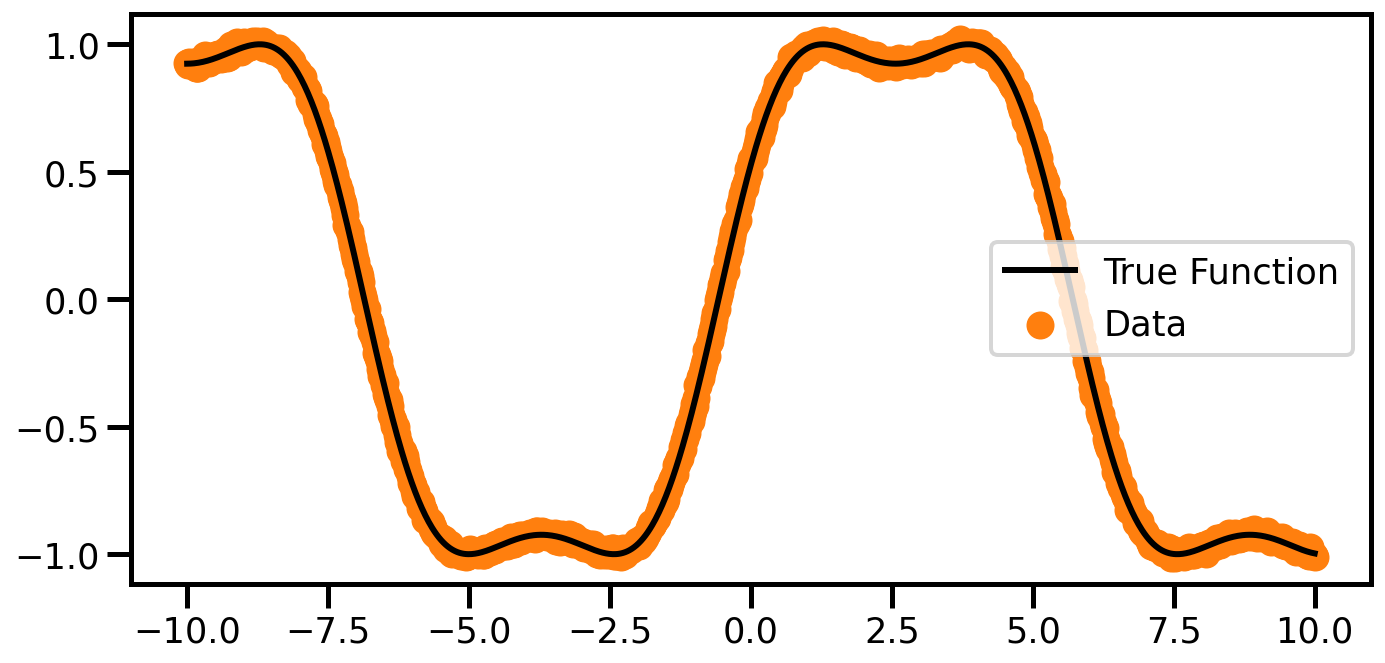

In [6]:
from src.data import regression_near_square

(
    Xtrain,
    Xtrain_noise,
    ytrain,
    xtest,
    xtest_noise,
    ytest,
    ytest_noise,
) = regression_near_square(
    n_train=1_000, n_test=1_000, x_noise=0.3, y_noise=0.01, seed=123, buffer=0.0
)

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(Xtrain, ytrain, color="tab:orange", label="Data")
ax.plot(xtest, ytest, color="black", label="True Function")
ax.legend()
plt.tight_layout()
plt.gcf()
wandb.log({"train_data_clean": wandb.Image(plt)})

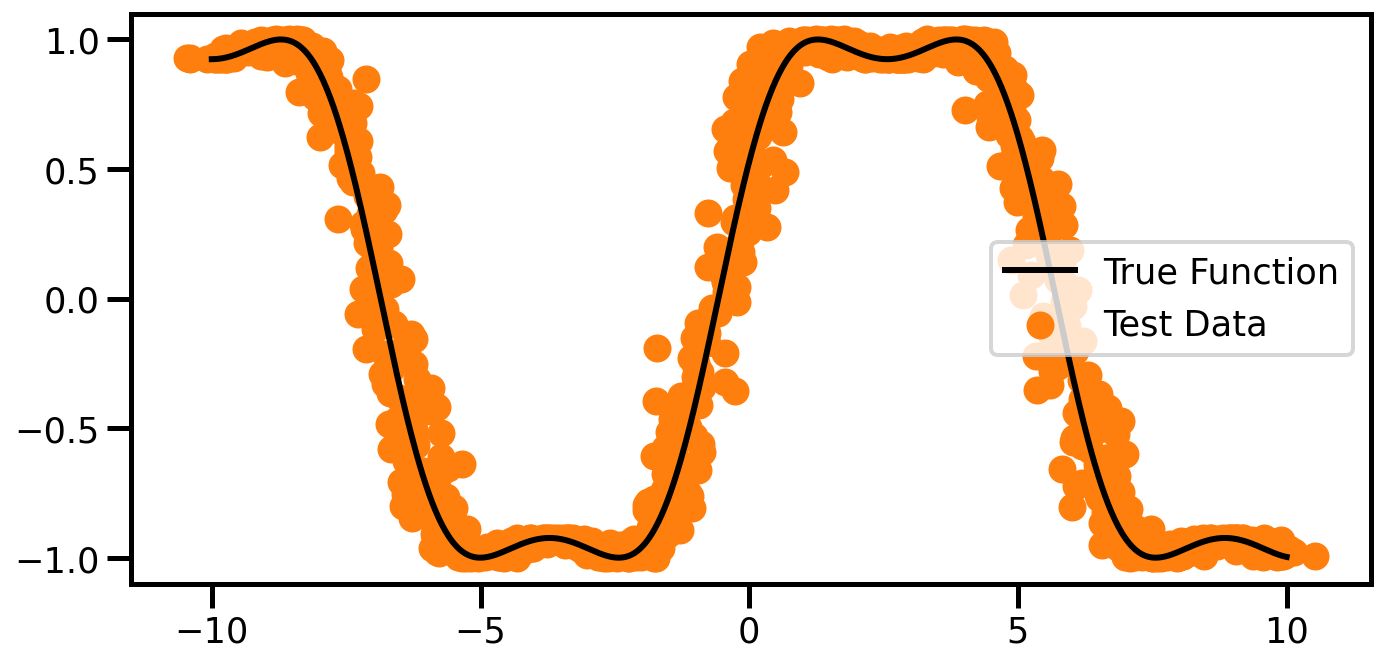

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(xtest_noise, ytest_noise, color="tab:orange", label="Test Data")
ax.plot(xtest, ytest, color="black", label="True Function")
ax.legend()
plt.tight_layout()
plt.gcf()
wandb.log({"test_data_noisy": wandb.Image(plt)})

## Gaussian Process Model

#### Kernel

In [8]:
from chex import Array
from src.utils import identity_matrix, add_to_diagonal
from src.kernels import RBF

rbf_kernel = RBF(length_scale=1.0, variance=1.0)
K = rbf_kernel.gram(Xtrain)

# check shape
chex.assert_shape(K, (Xtrain.shape[0], Xtrain.shape[0]))

#### Inducing Points

In [9]:
from src.utils import init_inducing_subsample, init_inducing_kmeans

n_inducing = 100

X_u_init = init_inducing_kmeans(Xtrain, n_inducing, seed=123)

### Model

In [10]:
from src.sparse import SGPVFE
from src.means import zero_mean
from chex import Array

jitter = 1e-5

inference = "map"
wandb.config.inference = inference


def numpyro_model(X, y):

    if inference == "map" or "vi_mf" or "vi_full":
        # Set priors on hyperparameters.
        η = numpyro.sample("variance", dist.HalfCauchy(scale=5.0))
        ℓ = numpyro.sample("length_scale", dist.Gamma(2.0, 1.0))
        σ = numpyro.sample("obs_noise", dist.HalfCauchy(scale=5.0))
    elif inference == "mll":

        # set params and constraints on hyperparams
        η = numpyro.param(
            "variance", init_value=1.0, constraints=dist.constraints.positive
        )
        ℓ = numpyro.param(
            "length_scale", init_value=1.0, constraints=dist.constraints.positive
        )
        σ = numpyro.param(
            "obs_noise", init_value=0.01, onstraints=dist.constraints.positive
        )
    else:
        raise ValueError(f"Unrecognized inference scheme: {inference}")

    x_u = numpyro.param("x_u", init_value=X_u_init)

    # Kernel Function
    rbf_kernel = RBF(variance=η, length_scale=ℓ)

    # GP Model
    gp_model = SGPVFE(
        X=X, X_u=x_u, y=y, mean=zero_mean, kernel=rbf_kernel, obs_noise=σ, jitter=jitter
    )

    # Sample y according SGP
    return gp_model.to_numpyro(y=y)


def empty_guide(X, y):
    pass

In [11]:
with numpyro.handlers.seed(rng_seed=123):
    t = numpyro_model(Xtrain, ytrain)

assert t.shape == Xtrain.shape

## Training (Maximum Likelihood)

In [12]:
from numpyro.infer.autoguide import (
    AutoDelta,
    AutoMultivariateNormal,
    AutoDiagonalNormal,
)

# ===================
# Model
# ===================
# GP model

# delta guide - basically deterministic


if inference == "map":
    guide = AutoDelta(numpyro_model)
elif inference == "vi_mf":
    guide = AutoDiagonalNormal(numpyro_model)
elif inference == "vi_full":
    guide = AutoMultivariateNormal(numpyro_model)
elif inference == "mll":

    def empty_guide(X, y):
        pass

    guide = empty_guide
else:
    raise ValueError(f"Unrecognized inference scheme: {inference}")

In [13]:
# reproducibility
rng_key = random.PRNGKey(0)


# Setup
wandb.config.step_size = 0.01
wandb.config.train_seed = 42
wandb.config.iterations = 2_500

optimizer = numpyro.optim.Adam(step_size=0.01)
# optimizer = numpyro.optim.Minimize()
# optimizer = optax.adamw(learning_rate=0.1)
svi = SVI(numpyro_model, guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(random.PRNGKey(1), 2_500, Xtrain, ytrain.T)

100%|██████████| 2500/2500 [00:41<00:00, 59.69it/s, init loss: 2006.3394, avg. loss [2376-2500]: -3067.9801]


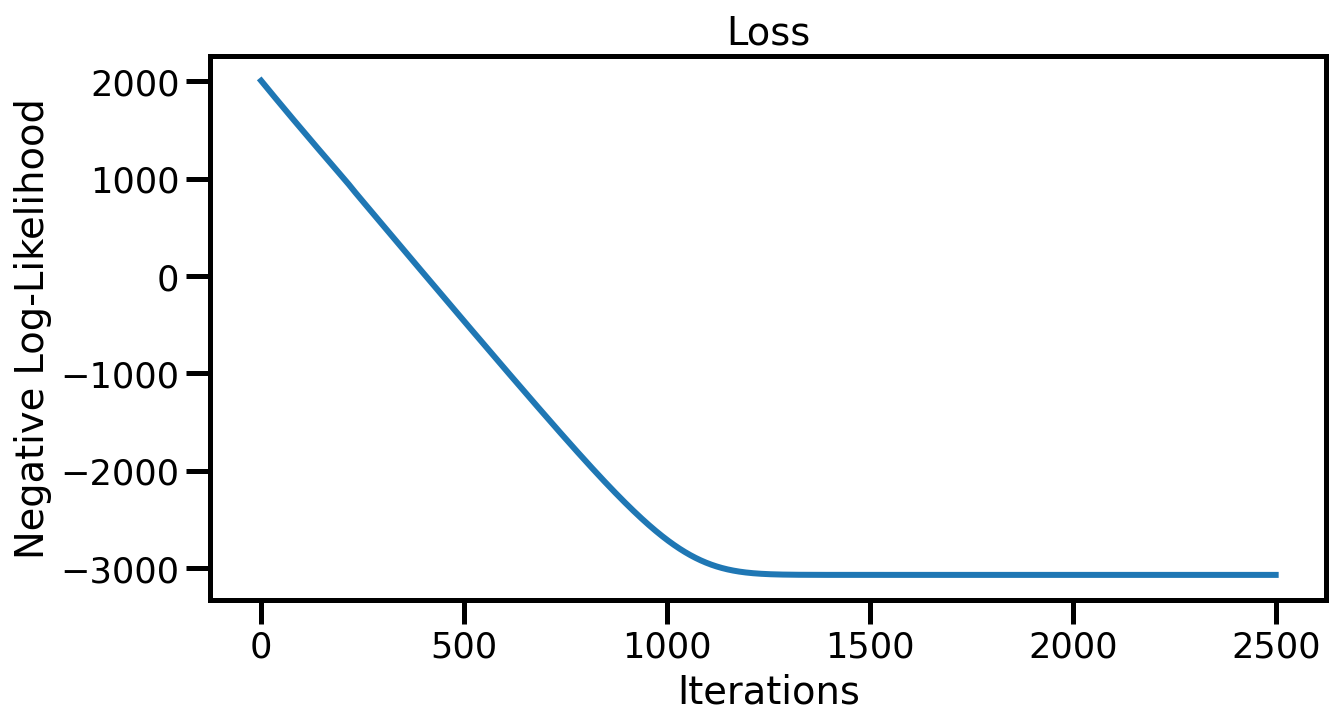

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(svi_results.losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.gcf()
wandb.log({"loss": wandb.Image(plt)})

### Extracting the Params

In [15]:
import numpy as np

In [16]:
from pprint import pprint

# Take them directly
learned_params = svi_results.params
# pprint(learned_params)

if inference != "mll":
    x_u = learned_params["x_u"]
    learned_params = guide.median(learned_params)
    learned_params["x_u"] = x_u


# wandb.log({"x_u": np.array(x_u)})
pprint(learned_params)

{'length_scale': DeviceArray(1.726, dtype=float64),
 'obs_noise': DeviceArray(0., dtype=float64),
 'variance': DeviceArray(0.642, dtype=float64),
 'x_u': DeviceArray([[  8.285],
             [ -5.198],
             [  2.503],
             [-10.269],
             [ -0.46 ],
             [  6.496],
             [ -9.459],
             [  0.575],
             [  4.504],
             [  1.614],
             [  5.467],
             [ -4.265],
             [ -3.406],
             [ -8.829],
             [  9.692],
             [ 10.237],
             [  7.363],
             [ -4.265],
             [  3.543],
             [ -1.353],
             [-11.018],
             [ -6.133],
             [ -8.829],
             [  2.995],
             [ -7.053],
             [  3.543],
             [  6.006],
             [ -2.381],
             [  1.134],
             [ -0.46 ],
             [ -1.353],
             [ -7.999],
             [  7.363],
             [ -6.133],
             [ -9.675],
      

### Predictions

In [17]:
from src.sparse import init_sgp_predictive

sgp_pred = init_sgp_predictive(RBF, learned_params, Xtrain, ytrain, jitter=1e-5)

mu, var = sgp_pred.predict_y(xtest)

std = jnp.sqrt(var.squeeze())

In [18]:
ci = 1.96
one_stddev = ci * std

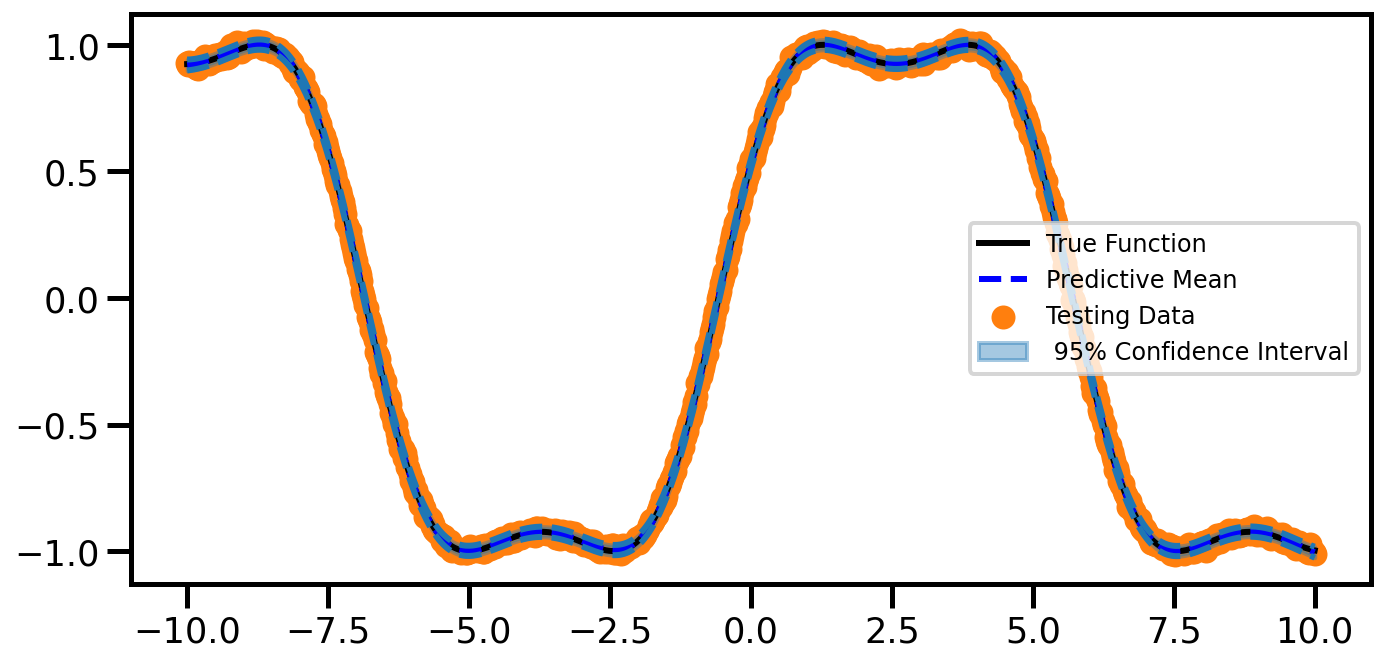

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(Xtrain, ytrain, marker="o", s=100, color="tab:orange", label="Testing Data")
ax.plot(xtest, ytest, color="black", linestyle="-", label="True Function")
ax.plot(
    xtest,
    mu.ravel(),
    color="Blue",
    linestyle="--",
    linewidth=3,
    label="Predictive Mean",
)
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
    label=f" 95% Confidence Interval",
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.tight_layout()
plt.legend(fontsize=12)
plt.gcf()
wandb.log({"esgp_pred_standard_clean": wandb.Image(plt)})

## Calibration

In [20]:
from uncertainty_toolbox import viz as utviz

#### Test Data

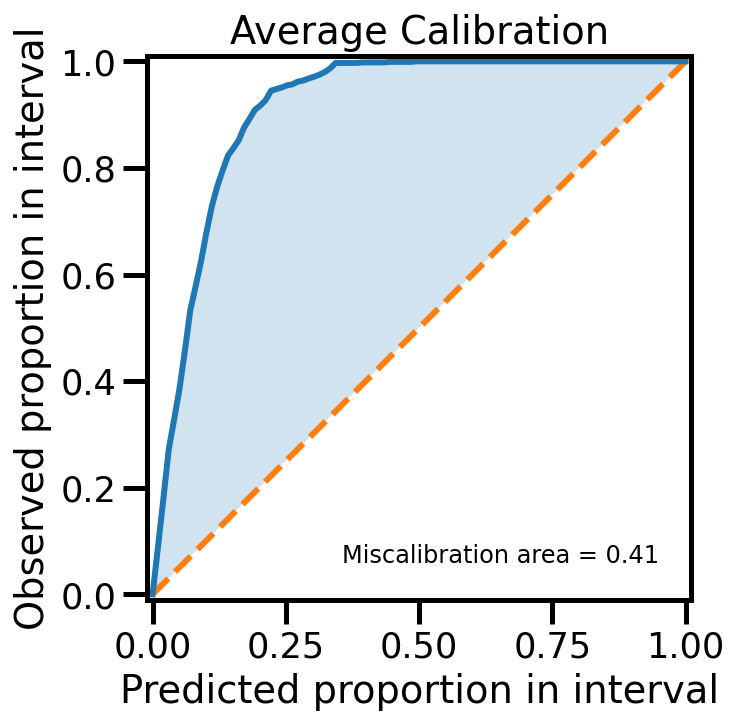

In [21]:
mu, var = sgp_pred.predict_y(xtest)

std = jnp.sqrt(var.squeeze())

utviz.plot_calibration(y_pred=mu.ravel(), y_std=std.ravel(), y_true=ytest.ravel())
plt.gcf()
wandb.log({"esgp_calib_standard_clean": wandb.Image(plt)})

## Noisy Test Data

In [22]:
mu, var = sgp_pred.predict_y(xtest_noise)

std = jnp.sqrt(var.squeeze())

ci = 1.96
one_stddev = ci * std

In [23]:
idx_samples = np.random.choice(np.arange(xtest_noise.shape[0]), 50)

In [24]:
def plot_noisy_predictions(mu, var, method):
    std = jnp.sqrt(var.squeeze())
    ci = 1.96
    one_stddev = ci * std
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(
        xtest_noise,
        ytest_noise,
        marker="o",
        s=30,
        color="tab:orange",
        label="Testing Data",
    )
    ax.plot(xtest, ytest, color="black", linestyle="-", label="True Function")
    ax.plot(
        xtest_noise,
        mu.ravel(),
        color="Blue",
        linestyle="--",
        linewidth=3,
        label="Predictive Mean",
    )
    ax.fill_between(
        xtest_noise.ravel(),
        mu.ravel() - one_stddev,
        mu.ravel() + one_stddev,
        alpha=0.4,
        color="tab:blue",
        label=f" 95% Confidence Interval",
    )
    ax.plot(xtest_noise, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
    ax.plot(xtest_noise, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
    plt.tight_layout()
    plt.legend(fontsize=12)
    plt.gcf()
    wandb.log({f"esgp_pred_{method}_noisy": wandb.Image(plt)})

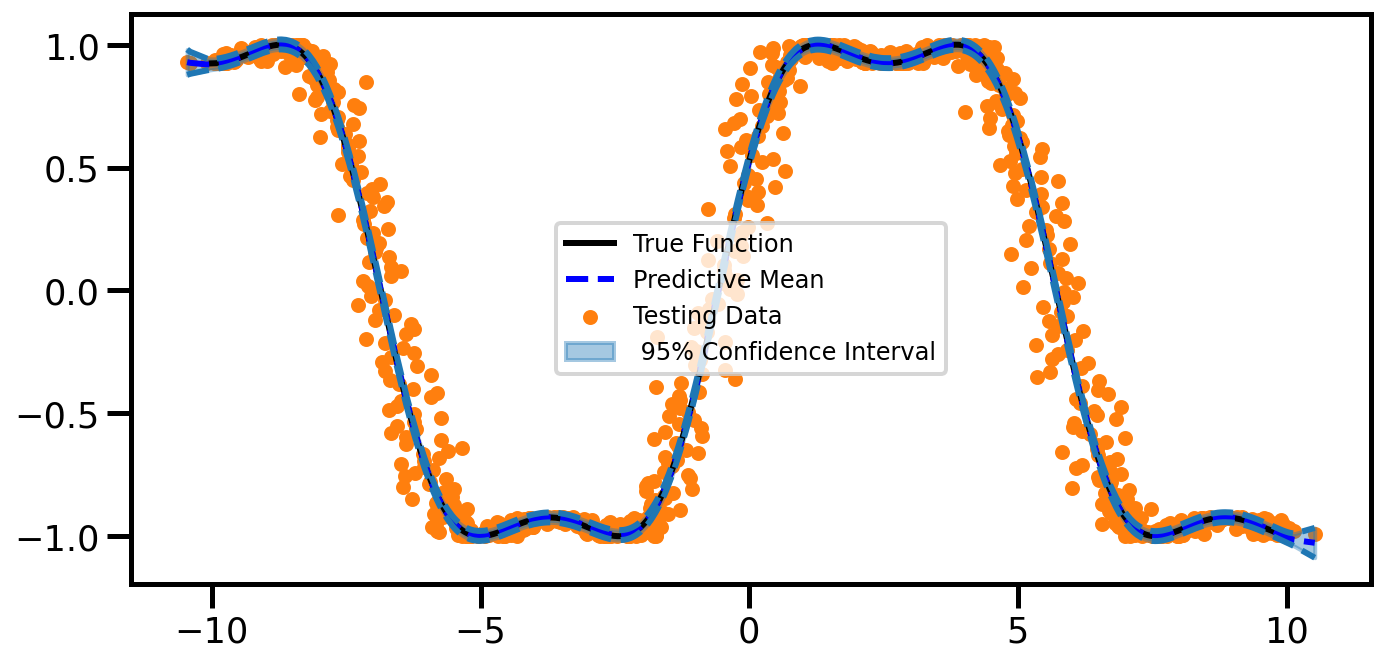

In [25]:
plot_noisy_predictions(mu, var, "standard")

In [26]:
def plot_calibrations(mu, var, method):
    std = jnp.sqrt(var.squeeze())
    ci = 1.96
    one_stddev = ci * std
    utviz.plot_calibration(
        y_pred=mu.ravel(), y_std=std.ravel(), y_true=ytest_noise.ravel()
    )
    plt.gcf()
    wandb.log({f"esgp_calib_{method}_noisy": wandb.Image(plt)})

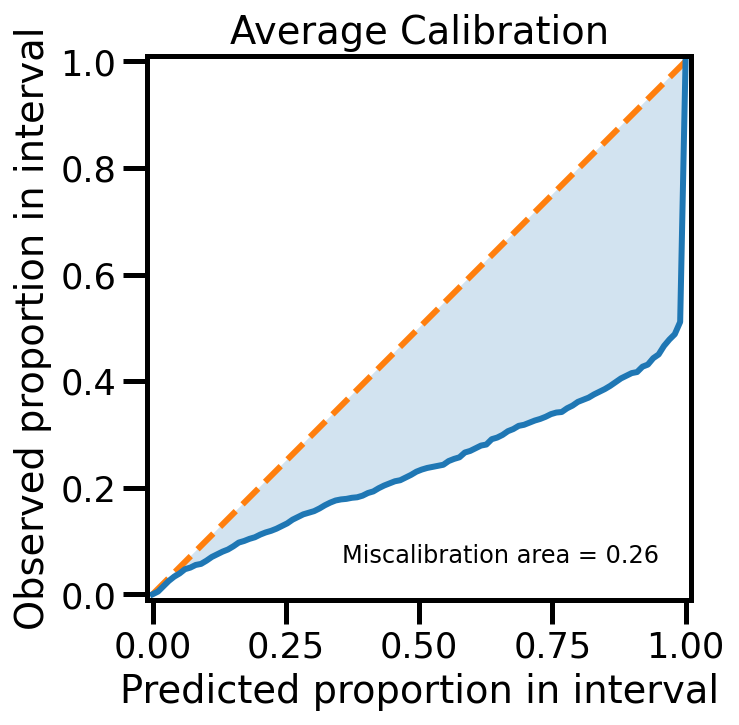

In [27]:
plot_calibrations(mu, var, "standard")

## Taylor Series Expansion

In [81]:
x_cov = jnp.array([0.3]).reshape(-1, 1) ** 2

f = lambda x: sgp_pred.predict_mean(x).squeeze()

jnp.hstack([xtest_noise, xtest_noise]).shape

(1000, 2)

In [84]:
from src.uncertain.taylor import init_taylor_o1_transform


egp_pred_taylor = init_taylor_o1_transform(sgp_pred)

mu_to1, var_to1 = egp_pred_taylor.predict_f(xtest_noise, x_cov, False, noiseless=False)
std_to1 = jnp.sqrt(var_to1).ravel()
mu_to1.shape, std_to1.shape

((1000, 1), (1000,))

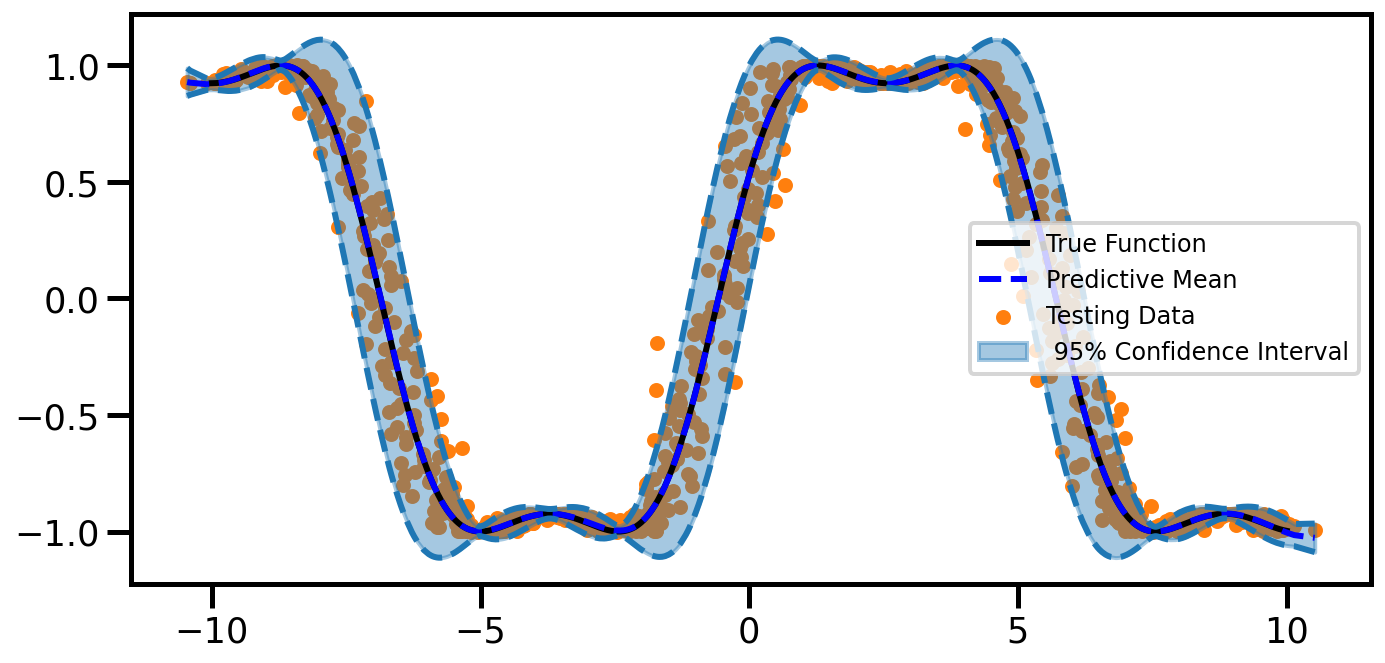

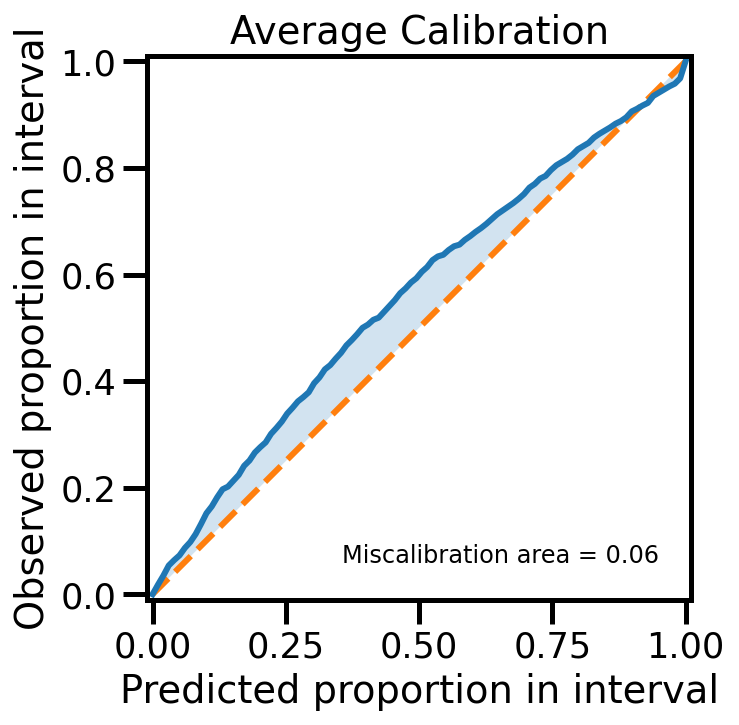

In [85]:
plot_noisy_predictions(mu_to1, var_to1, "taylor_o1")
plot_calibrations(mu_to1, var_to1, "taylor_o1")